In [1]:
import anndata as ad
import numpy as np
from pycpd import DeformableRegistration

import moscot as mt
import squidpy as sq

/Users/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
adata = ad.read_h5ad("/Users/giovanni.palla/Datasets/alignment.h5ad")
adata.obs.synth_batch.unique()
# ['0', '1', '2', '3', '4', '5', '6', '7']
# adata = adata[adata.obs.synth_batch == str(dataset["batch"])].copy()
# adata.X = rng.normal(size=adata.X.shape) + adata.X.copy()

/Users/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


['0', '1', '2', '3', '4', '5', '6', '7']
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

In [3]:
# sq.pl.spatial_scatter(adata, color="batch", shape=None)

In [4]:
rng = np.random.default_rng(42)
adata = adata[adata.obs.synth_batch == str(1)].copy()
adata.X = rng.normal(size=adata.X.shape) + adata.X.copy()
adata.obs

,batch,idx,synth_batch
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
795,1,395,1
796,1,396,1
797,1,397,1
798,1,398,1


In [5]:
ap = mt.problems.AlignmentProblem(adata)
ap = ap.prepare(batch_key="batch")
ap = ap.solve()

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(400, 400)].                                            


I0000 00:00:1707381399.947916       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [86]:
metrics = []
for i in ["0", "1", "2", "3", "4", "5", "6", "7"]:
    rng = np.random.default_rng(int(i))
    adata_sim = adata[adata.obs.synth_batch == str(1)].copy()
    adata_sim.X = rng.normal(size=adata_sim.X.shape) + adata.X.copy()
    p = 0.9
    idx_subsample = rng.choice([True, False], size=(adata_sim.shape[0]), p=[p, 1 - p])
    adata_sim = adata_sim[idx_subsample].copy()
    adata_sim.obs["batch"] = adata_sim.obs["batch"].astype(str)
    adata_sim.obsm["spatial"][450:] = adata_sim.obsm["spatial"][450:] + 2
    adata_source = adata_sim[adata_sim.obs.batch == "0"].copy()
    adata_target = adata_sim[adata_sim.obs.batch == "1"].copy()
    adata_source.obsm["spatial_tgt"] = adata_source.obsm["spatial"]
    adata_target.obsm["spatial_tgt"] = adata_target.obsm["spatial"]

    # create a RigidRegistration object
    reg = DeformableRegistration(
        X=adata_source.obsm["spatial"], Y=adata_target.obsm["spatial"]
    )
    # run the registration & collect the results
    out, _ = reg.register()
    adata_target.obsm["spatial_tgt"] = out

    _, comm1, comm2 = np.intersect1d(
        adata_source.obs.idx, adata_target.obs.idx, return_indices=True
    )
    error_cpd = (
        np.mean(
            adata_target.obsm["spatial_tgt"][comm2, :]
            - adata_source.obsm["spatial_tgt"][comm1, :]
        )
        ** 2
    )
    ap = mt.problems.AlignmentProblem(adata_sim)
    ap = ap.prepare(batch_key="batch")
    ap = ap.solve()
    ap.align(reference="0", key_added="spatial_moscot")
    ad1 = adata_sim[adata_sim.obs.batch == "0"].copy()
    ad2 = adata_sim[adata_sim.obs.batch == "1"].copy()
    _, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)
    error_moscot_default = (
        np.mean(ad1.obsm["spatial_moscot"][comm1] - ad2.obsm["spatial_moscot"][comm2])
        ** 2
    )
    ap = mt.problems.AlignmentProblem(adata_sim)
    ap = ap.prepare(batch_key="batch")
    ap = ap.solve(alpha=0.3)
    ap.align(reference="0", key_added="spatial_moscot")
    ad1 = adata_sim[adata_sim.obs.batch == "0"].copy()
    ad2 = adata_sim[adata_sim.obs.batch == "1"].copy()
    _, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)
    error_moscot_alpha = (
        np.mean(ad1.obsm["spatial_moscot"][comm1] - ad2.obsm["spatial_moscot"][comm2])
        ** 2
    )
    metrics.append(
        {
            "moscot-default": error_moscot_default,
            "d-cpd": error_cpd,
            "moscot-alpha=0.2": error_moscot_alpha,
        }
    )
    if error_moscot_alpha < 1e-6:
        adata_source_ex, adata_target_ex, adata_sim_ex = (
            adata_source,
            adata_target,
            adata_sim,
        )

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(349, 354)].                                            
WARNING  Solver did not converge                                                                                   
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                        

In [92]:
import pandas as pd

df = pd.DataFrame(metrics).melt()
df.columns = ["method", "mse"]
df

,method,mse
0,moscot-default,7.791542e-04
1,moscot-default,3.548656e-06
2,moscot-default,5.009060e-05
3,moscot-default,5.546657e-05
4,moscot-default,4.623098e-07
5,moscot-default,3.622920e-04
6,moscot-default,1.436595e-04
7,moscot-default,1.100935e-04
8,d-cpd,1.422889e-03
9,d-cpd,1.204339e-04


/var/folders/b2/j8d696xn30qch16zmxwy376c0000gn/T/ipykernel_2457/231221447.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Users/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


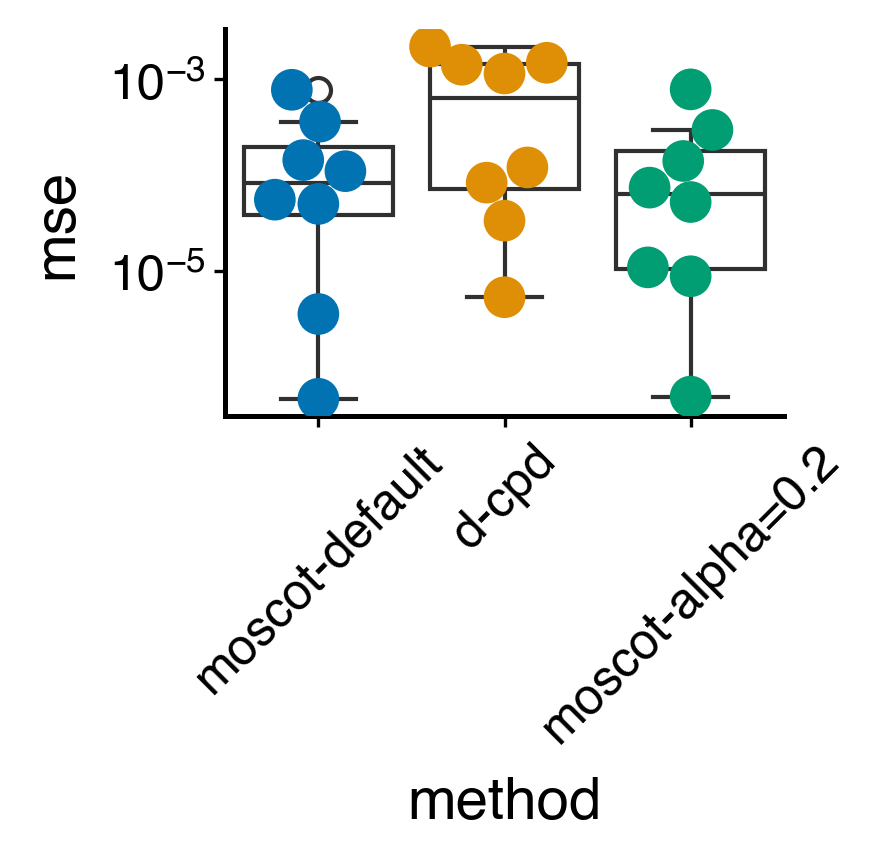

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

plt.rcParams["legend.scatterpoints"] = 1
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
# palette = "deep"

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        # hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        # labels=[label]
    ).set_yscale("log")
    sns.swarmplot(
        x=x, y=y, hue=x, palette="colorblind", size=10, dodge=False, *args, **kwargs
    ).set_yscale("log")
    plt.xticks(rotation=45)


g = sns.FacetGrid(df)

g.map(fixed_boxplot, "method", "mse")
axes = g.axes.flatten()

/Users/giovanni.palla/Projects/squidpy/src/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/giovanni.palla/Projects/squidpy/src/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


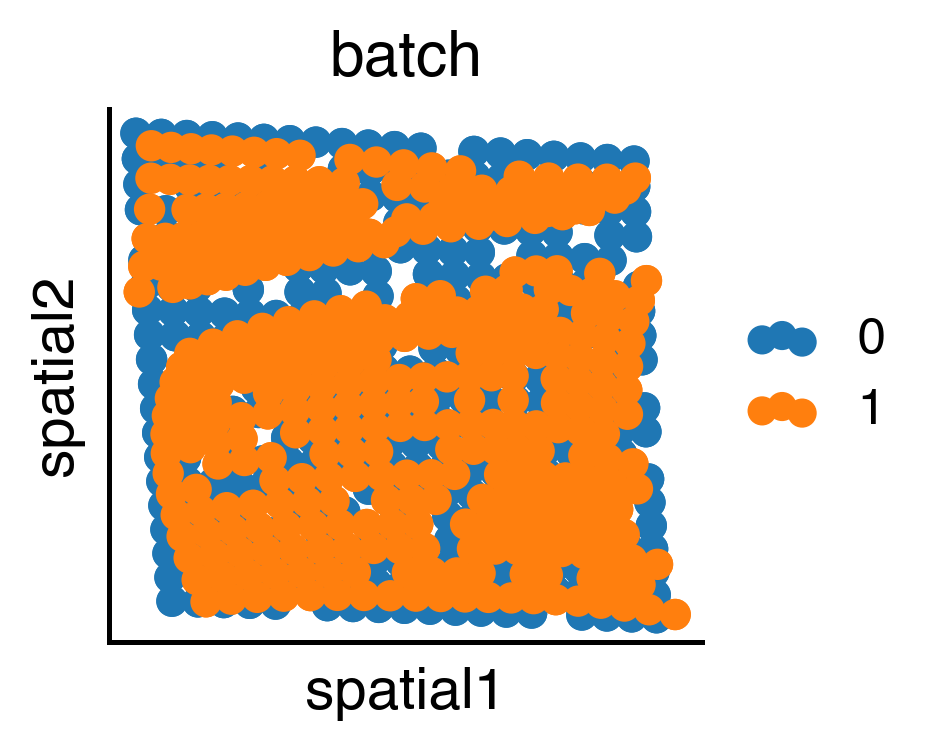

In [94]:
adata_out = ad.concat([adata_source_ex, adata_target_ex])
sq.pl.spatial_scatter(
    adata_out,
    color="batch",
    shape=None,
    spatial_key="spatial_tgt",
    axis_label=["spatial1", "spatial2"],
)

/Users/giovanni.palla/Projects/squidpy/src/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/giovanni.palla/Projects/squidpy/src/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


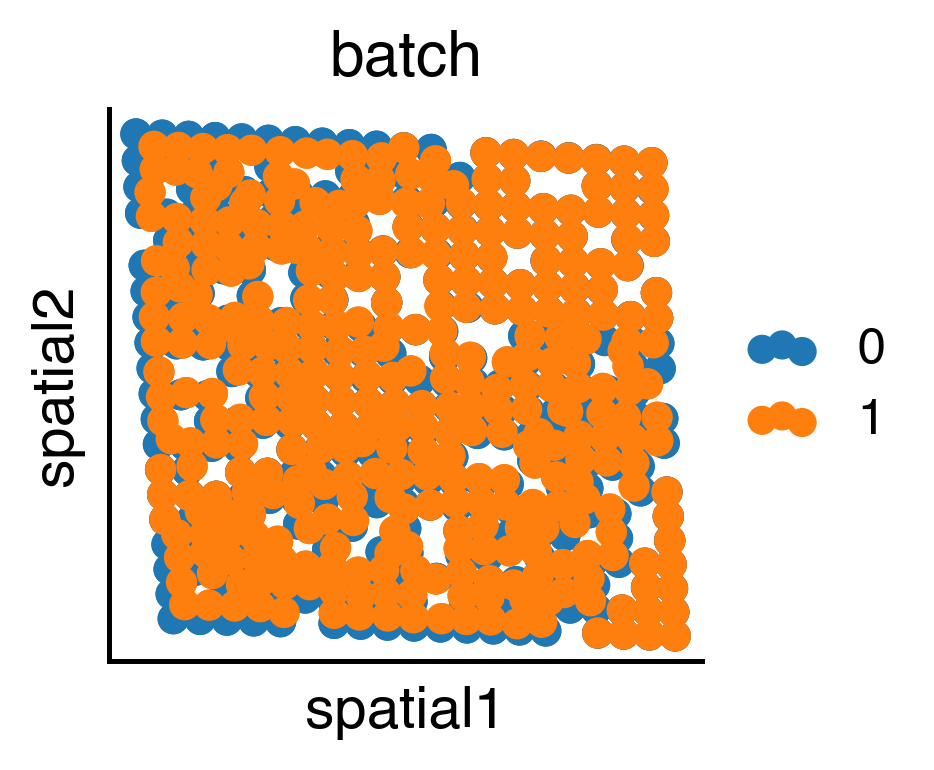

In [95]:
sq.pl.spatial_scatter(
    adata_sim_ex,
    color="batch",
    shape=None,
    spatial_key="spatial_moscot",
    axis_label=["spatial1", "spatial2"],
)

/Users/giovanni.palla/Projects/squidpy/src/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/giovanni.palla/Projects/squidpy/src/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


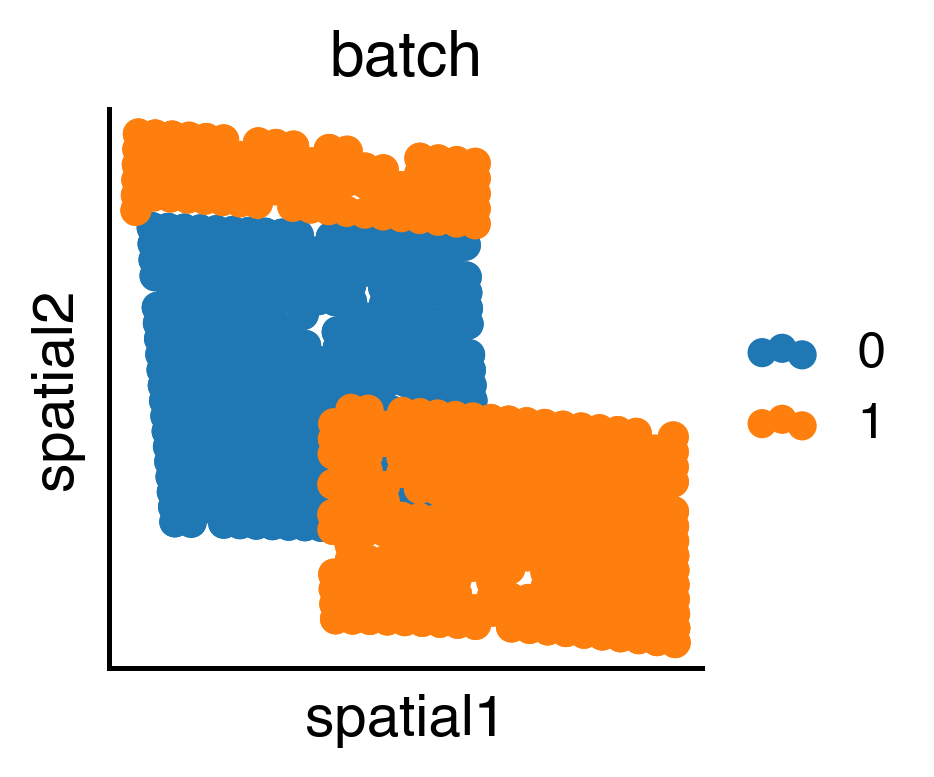

In [96]:
sq.pl.spatial_scatter(
    adata_sim,
    color="batch",
    shape=None,
    spatial_key="spatial",
    axis_label=["spatial1", "spatial2"],
)